In [3]:
from pathlib import Path
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

from scipy.stats import lognorm

from astropy import stats
from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support, hist
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, TETE
from astropy.table import Table
from astropy.io import ascii

from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, analyze_dimm_cube, seeing

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x7f415f688fe0>

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@05-14-13.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@05-08-47.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@04-33-55.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@04-23-53.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-54-30.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-53-10.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2023-12-13@02-38-45.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_procyon_2023-12-13@08-01-56.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_capella_2023-12-13@10-19-07.ser"
testfile = Path.home() / "MMT/fassdimm_data/indi_record_2024-05-24@07-57-52.ser"
#testfile = Path.home() / "MMT/fassdimm_data/indi_record_2024-05-24@07-11-02.ser"

d = load_ser_file(testfile)

(<Quantity 0.91662508 arcsec>,
 [<Quantity 0.95616115 arcsec>,
  <Quantity 0.89117385 arcsec>,
  <Quantity 0.90254023 arcsec>],
 0)

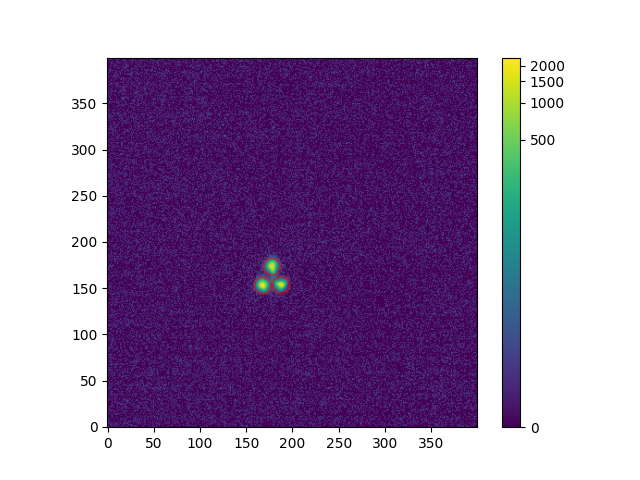

In [147]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
airmass = 1.0
results = analyze_dimm_cube(testfile, airmass=airmass, seeing_func=seeing, napertures=3, ap_size=9, plot=True)
results["seeing"], results['raw_seeing'], results['N_bad']

In [103]:
d['data'].shape

(2882, 400, 400)

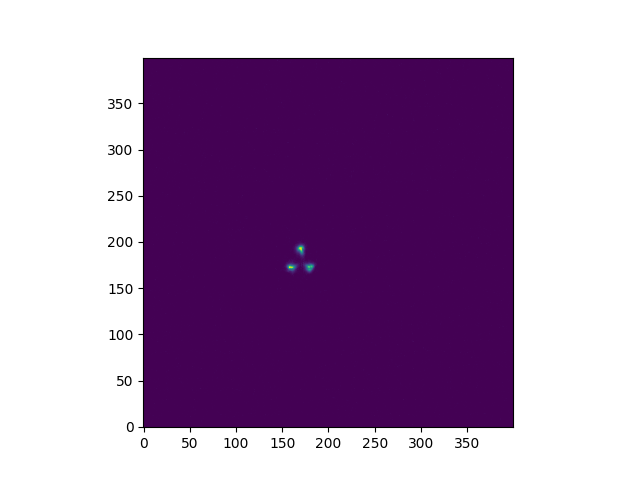

(1936, 16.0)

In [148]:
fig, ax = plt.subplots()
idx = 500
#ax.imshow(np.mean(d["data"][1005:1006], axis=0), origin="lower")
ax.imshow(d["data"][idx], origin="lower")
plt.show()
d["data"][idx].max(), np.median(d["data"][idx])

In [46]:
np.mean(d["data"], axis=(1,2))

array([157.2196, 157.3518, 157.8135, ..., 157.5162, 157.4143, 157.9766])

/home/tim/conda/envs/timdimm/lib/python3.12/site-packages/photutils/detection/daofinder.py:640: RuntimeWarning: divide by zero encountered in divide
  return ((self.convdata_peak / self.threshold_eff)


array([80870.85928081, 41055.61528848, 61295.93126615])

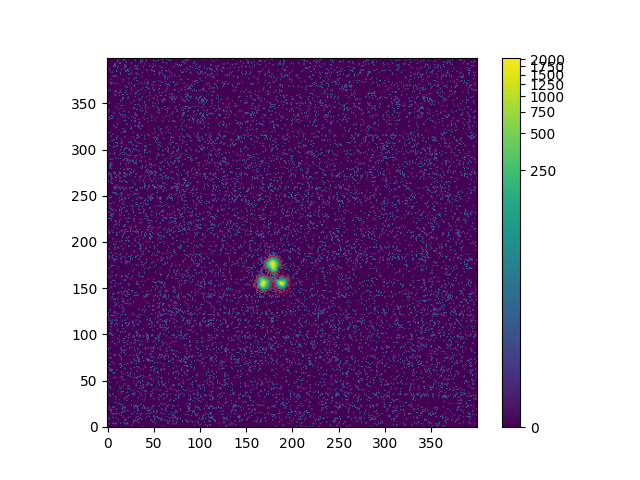

In [157]:
ap_im = np.mean(d["data"][:1], axis=0)
aps = find_apertures(ap_im, fwhm=9, ap_size=9, plot=True)
ap_stats = ApertureStats(ap_im, aps[0])
np.mean(ap_stats.centroid, axis=0), (ap_stats.max.max() > 16000),
ap_stats.sum

In [14]:
ave_im = np.mean(d['data'][:10], axis=0)
aps = find_apertures(ave_im, brightest=2)
ap_stats = ApertureStats(ave_im, aps[0])
ap_stats.centroid, ap_stats.max, np.mean(ap_stats.centroid, axis=0)

(array([[226.84209193, 192.4279562 ],
        [182.68432396, 207.55939958]]),
 array([2801.6, 1540.8]),
 array([204.76320794, 199.99367789]))

In [33]:
ap_stats.max.max()

668.8

In [34]:
x, y = np.mean(ap_stats.centroid, axis=0)
x, y

(175.57218138617034, 211.53527219935097)

In [58]:
results['N_bad']

0

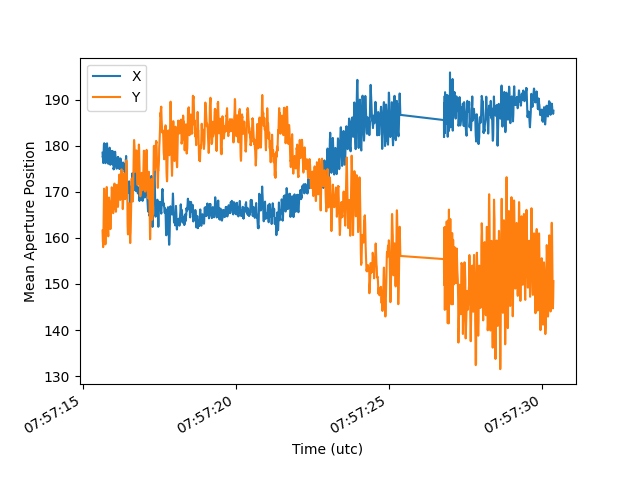

In [150]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [75]:
np.argmax(results["aperture_positions"][0])

1016

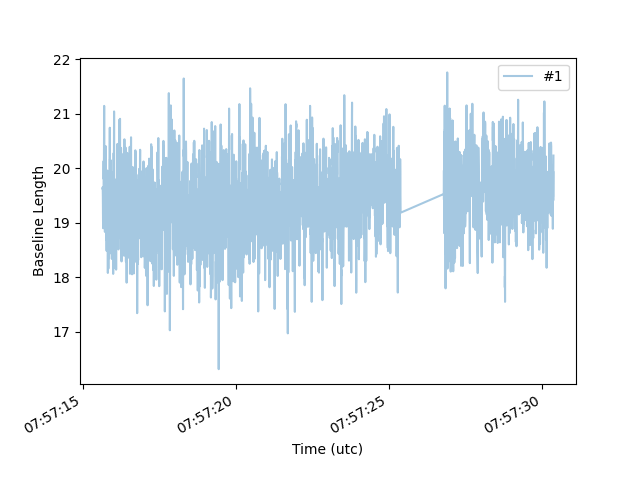

In [151]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

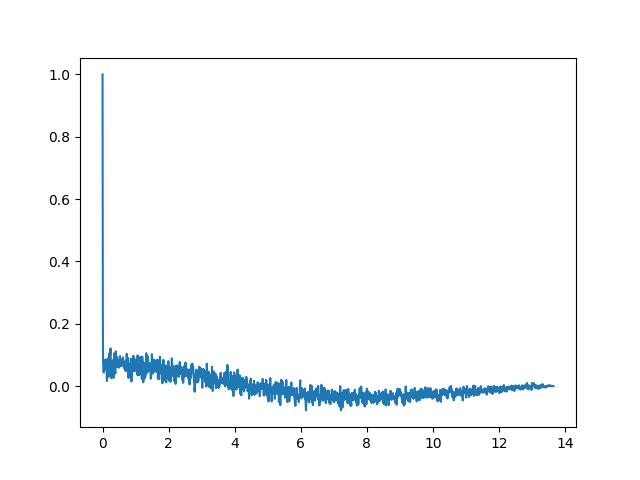

In [152]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()